In [3]:
!pip install tensorflow==2.8.0
!pip install keras==2.8.0
!pip install tensorflow-addons==0.17.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 99.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 103.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 75.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data-server-0.7.1
  Attempting uninstall: google-auth-oauthlib
    Found existing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.8.0 which is incompatible.


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [2]:
num_classes=10
input_shape=(32,32,3)

#load cifar 10
(x_train,y_train),(x_test,y_test)=keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170508288/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [12]:
learning_rate=0.001
weight_decay=0.0001
batch_size=256
num_epochs=15
image_size=72
patch_size=6
num_patches=(image_size//patch_size)**2
num_heads=4
projection_dim=64
transformer_units=[
    projection_dim*2,
    projection_dim
]
transformer_layers=8
mlp_head_units=[2048,1024]

In [4]:
data_augmentation=keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size,image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
        height_factor=0.2,width_factor=0.2)
    ],
    name="data_augmentation"
)
data_augmentation.layers[0].adapt(x_train)

In [5]:
def mlp(x,hidden_units,dropout_rate):
    for units in hidden_units:
        x=layers.Dense(units,activation=tf.nn.gelu)(x)
        x=layers.Dropout(dropout_rate)(x)
    return x

In [6]:
class Patches(layers.Layer):
    def __init__(self,patch_size):
        super(Patches,self).__init__()
        self.patch_size=patch_size

    def call(self,images):
        batch_size=tf.shape(images)[0]
        patches=tf.image.extract_patches(
            images=images,
            sizes=[1,self.patch_size,self.patch_size,1],
            strides=[1,self.patch_size,self.patch_size,1],
            rates=[1,1,1,1],
            padding="VALID"
        )
        patch_dims=patches.shape[-1]
        patches=tf.reshape(patches,[batch_size,-1,patch_dims])
        return patches

Image size: 72 x 72
Patch size: 6 x 6
Patches per image: 144
Elements per patch: 108


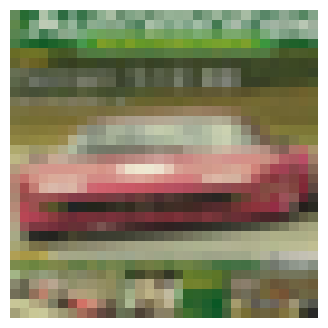

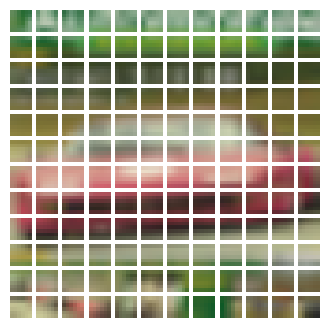

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
image=x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image=tf.image.resize(
    tf.convert_to_tensor([image]),size=(image_size,image_size)
)
patches=Patches(patch_size)(resized_image)
print(f"Image size: {image_size} x {image_size}")
print(f"Patch size: {patch_size} x {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n=int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
    ax=plt.subplot(n,n,i+1)
    patch_img=tf.reshape(patch,(patch_size,patch_size,3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [8]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [9]:
def create_vit_classifier():
        inputs=layers.Input(shape=input_shape)
        #augment data
        augmented=data_augmentation(inputs)
        #create patches
        patches=Patches(patch_size)(augmented)
        #encode patches
        encoded_patches=PatchEncoder(num_patches,projection_dim)(patches)

        #create multiple layers of transformer block
        for _ in range(transformer_layers):
            #layer normalisation 1
            x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
            #create a multi head attention layer
            attention_output=layers.MultiHeadAttention(
                num_heads=num_heads,key_dim=projection_dim,dropout=0.1
            )(x1,x1)
            #skip connection 1
            x2=layers.Add()([attention_output,encoded_patches])
            #layer normalisation 2
            x3=layers.LayerNormalization(epsilon=1e-6)(x2)
            #MLP
            x3=mlp(x3,hidden_units=transformer_units,dropout_rate=0.1)
            #skip connection 2
            encoded_patches=layers.Add()([x3,x2])

        #create a [batch_size,projection_dim] tensor
        representation=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        representation=layers.Flatten()(representation)
        representation=layers.Dropout(0.5)(representation)

        #add mlp
        features=mlp(representation,hidden_units=mlp_head_units,dropout_rate=0.5)

        #classify outputs
        logits=layers.Dense(num_classes)(features)

        #create keras model
        model=keras.Model(inputs=inputs,outputs=logits)
        return model

In [10]:
def run_experiment(model):
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5,name="top-5-accuracy")
        ]
    )

    checkpoint_filepath="./tmp/checkpoint"
    checkpoint_callback=keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True
    )

    history=model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback]
    )

    model.load_weights(checkpoint_filepath)
    _,accuracy,top_5_accuracy=model.evaluate(x_test,y_test)
    print(f"Test accuracy: {round(accuracy*100,2)}%")
    print(f"Test Top 5 accuracy: {round(top_5_accuracy*100,2)}%")

In [13]:
vit_classifier=create_vit_classifier()
history=run_experiment(vit_classifier)

Epoch 1/15
176/176 [==============================] - 86s 426ms/step - loss: 2.0059 - accuracy: 0.3267 - top-5-accuracy: 0.8157 - val_loss: 1.4912 - val_accuracy: 0.4562 - val_top-5-accuracy: 0.9114
Epoch 2/15
176/176 [==============================] - 73s 415ms/step - loss: 1.5355 - accuracy: 0.4494 - top-5-accuracy: 0.9039 - val_loss: 1.2247 - val_accuracy: 0.5554 - val_top-5-accuracy: 0.9476
Epoch 3/15
176/176 [==============================] - 71s 406ms/step - loss: 1.3751 - accuracy: 0.5093 - top-5-accuracy: 0.9288 - val_loss: 1.1221 - val_accuracy: 0.6036 - val_top-5-accuracy: 0.9590
Epoch 4/15
176/176 [==============================] - 68s 385ms/step - loss: 1.2865 - accuracy: 0.5452 - top-5-accuracy: 0.9371 - val_loss: 1.1033 - val_accuracy: 0.6078 - val_top-5-accuracy: 0.9624
Epoch 5/15
176/176 [==============================] - 71s 403ms/step - loss: 1.2069 - accuracy: 0.5729 - top-5-accuracy: 0.9472 - val_loss: 0.9913 - val_accuracy: 0.6544 - val_top-5-accuracy: 0.9730
Epoch

In [14]:
class_names=[
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

In [19]:
def img_predict(images,model):
    if len(images.shape)==3:
        out=model.predict(images.reshape(-1,*images.shape))
    else:
        out=model.predict(images)
    prediction=np.argmax(out,axis=1)
    img_prediction=[class_names[i] for i in prediction]
    return img_prediction

['truck']


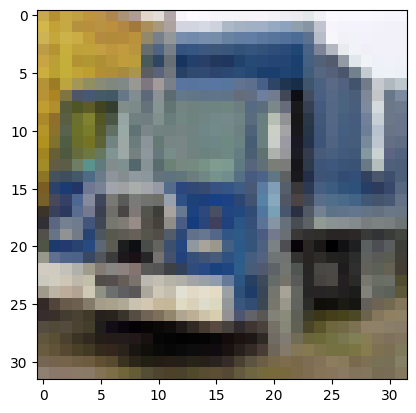

In [20]:
index=14
plt.imshow(x_test[index])
prediction=img_predict(x_test[index],vit_classifier)
print(prediction)